Assigment 2

Team Memeber(s): 1. MD Junayed Talukdar, 
                 2. Duy Tran, 
                 3. Syed Muhammad Usman
Application Start from here. 
Importing necessary libraries to support our developmet. A requirements.txt file is attached with this project to help install the necessary libs.


In [ ]:
import os
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

### Database setup and CSV loading
### - Applies schema.sql if present.
### - Loads CSV files from the Data/ folder into the SQLite database.


In [ ]:
DB_PATH = "studentJourney.db"
DATA_DIR = "Data"

# Connect to database (creates file if not exists)
conn = sqlite3.connect(DB_PATH)
print(f"Connected to database: {DB_PATH}")

# Load and execute schema
try:
    with open("schema.sql", "r", encoding="utf-8") as f:
        ddl = f.read()
    conn.executescript(ddl)
    print("Schema created successfully")
except FileNotFoundError:
    print("Warning: schema.sql not found, tables may need manual creation")

# Define table names (must match CSV filenames and schema)
tables = [
    "Department_Information",
    "Employee_Information",
    "Student_Counceling_Information",  # Note: Keep spelling consistent with CSV
    "Student_Performance_Data"
]

# Load each CSV and insert into database
for table_name in tables:
    csv_path = os.path.join(DATA_DIR, f"{table_name}.csv")
    try:
        df = pd.read_csv(csv_path)
        df.to_sql(table_name, conn, if_exists="replace", index=False)
        print(f"Loaded {table_name}: {len(df)} rows")
    except FileNotFoundError:
        print(f"Error: {csv_path} not found")
    except Exception as e:
        print(f"Error loading {table_name}: {e}")

# Verify tables exist
tables_in_db = pd.read_sql_query(
    "SELECT name FROM sqlite_master WHERE type='table';", 
    conn
)
print(f"\nTables in database:\n{tables_in_db}")

Connected to database: studentJourney.db
Schema created successfully
Loaded Department_Information: 47 rows
Loaded Employee_Information: 1000 rows
Loaded Student_Counceling_Information: 4000 rows
Loaded Student_Performance_Data: 209610 rows

Tables in database:
                             name
0          Department_Information
1            Employee_Information
2  Student_Counceling_Information
3        Student_Performance_Data


### Data quality validation
### - Load relevant tables into pandas for checks.
### - Store exception DataFrames in `reports` for export later.


In [ ]:
# Dictionary to store exception reports
reports = {}

# Load tables for validation
dept = pd.read_sql_query("SELECT * FROM Department_Information", conn)
emp = pd.read_sql_query("SELECT * FROM Employee_Information", conn)
coun = pd.read_sql_query("SELECT * FROM Student_Counceling_Information", conn)
perf = pd.read_sql_query("SELECT * FROM Student_Performance_Data", conn)

print(f"\nLoaded data for validation:")
print(f"  - Departments: {len(dept)} rows")
print(f"  - Employees: {len(emp)} rows")
print(f"  - Counseling: {len(coun)} rows")
print(f"  - Performance: {len(perf)} rows")


Loaded data for validation:
  - Departments: 47 rows
  - Employees: 1000 rows
  - Counseling: 4000 rows
  - Performance: 209610 rows


### Department Validation

In [ ]:
# Check 1: Missing values
reports["dept_missing"] = dept[dept.isna().any(axis=1)]
print(f"Missing values: {len(reports['dept_missing'])} rows")

# Check 2: Duplicate Department_IDs
reports["dept_duplicate_id"] = dept[
    dept.duplicated(subset=["Department_ID"], keep=False)
]
print(f"Duplicate Department_IDs: {len(reports['dept_duplicate_id'])} rows")

# Check 3: Duplicate Department_Names
reports["dept_duplicate_name"] = dept[
    dept.duplicated(subset=["Department_Name"], keep=False)
]
print(f"Duplicate Department_Names: {len(reports['dept_duplicate_name'])} rows")

# Check 4: Invalid DOE (year < 1900 or invalid date)
def is_invalid_doe(doe_val):
    """Check if DOE is invalid (missing, empty, or year < 1900)"""
    if pd.isna(doe_val) or str(doe_val).strip() == '':
        return True
    try:
        # Try to parse as date
        date_obj = pd.to_datetime(doe_val, errors='coerce')
        if pd.isna(date_obj):
            return True
        return date_obj.year < 1900
    except:
        return True

reports["dept_invalid_doe"] = dept[dept["DOE"].apply(is_invalid_doe)]
print(f"Invalid DOE (year < 1900): {len(reports['dept_invalid_doe'])} rows")

Missing values: 2 rows
Duplicate Department_IDs: 10 rows
Duplicate Department_Names: 2 rows
Invalid DOE (year < 1900): 3 rows


C:\Users\Duy Tran\AppData\Local\Temp\ipykernel_10860\1932869721.py:24: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  date_obj = pd.to_datetime(doe_val, errors='coerce')


### Student Counseling Validation

In [ ]:
# Check 1: Missing Department_Admission values
reports["coun_missing"] = coun[coun["Department_Admission"].isna()]
print(f"Missing Department_Admission: {len(reports['coun_missing'])} rows")

# Check 2: Department_Admission doesn't exist in Department table
dept_ids = set(dept["Department_ID"].dropna().astype(str).str.strip())
coun_clean = coun.copy()
coun_clean["Department_Admission"] = coun_clean["Department_Admission"].astype(str).str.strip()

reports["coun_bad_admission"] = coun_clean[
    ~coun_clean["Department_Admission"].isin(dept_ids)
]
print(f"Invalid Department_Admission: {len(reports['coun_bad_admission'])} rows")


Missing Department_Admission: 1 rows
Invalid Department_Admission: 1 rows


### Performance Validation

In [ ]:
# Check 1: Missing values
reports["perf_missing"] = perf[perf.isna().any(axis=1)]
print(f"Missing values: {len(reports['perf_missing'])} rows")

# Check 2: Invalid Marks (not in range 0-100)
reports["perf_bad_marks"] = perf[
    perf["Marks"].notna() & ~perf["Marks"].between(0, 100)
]
print(f"Invalid Marks (not 0-100): {len(reports['perf_bad_marks'])} rows")

# Check 3: Invalid Effort_Hours (negative values only)
reports["perf_bad_effort"] = perf[
    (perf["Effort_Hours"].notna()) & (perf["Effort_Hours"] < 0)
]
print(f"Invalid Effort_Hours (< 0): {len(reports['perf_bad_effort'])} rows")

# Check 4: Duplicate (Student_ID, Paper_ID) pairs
reports["perf_dup_pair"] = perf[
    perf.duplicated(subset=["Student_ID", "Paper_ID"], keep=False)
]
print(f"Duplicate (Student_ID, Paper_ID): {len(reports['perf_dup_pair'])} rows")


Missing values: 3 rows
Invalid Marks (not 0-100): 5 rows
Invalid Effort_Hours (< 0): 1 rows
Duplicate (Student_ID, Paper_ID): 0 rows


### Exception Report Summary:
### - Print concise counts and keep DataFrames in `reports` for export.

In [ ]:
for report_name, report_df in reports.items():
    print(f"\n{'='*60}")
    print(f"{report_name.upper()}")
    print(f"{'='*60}")
    
    if report_df.empty:
        print("No exceptions found")
    else:
        print(f"Found {len(report_df)} exception(s)")
        display(report_df.head(10))


DEPT_MISSING
Found 2 exception(s)


,Department_ID,Department_Name,DOE
21,IDEPT5528,Sanitation and Digital Gaming,None
39,IDEPT9009,Laser Technology Enhancements,None



DEPT_DUPLICATE_ID
Found 10 exception(s)


,Department_ID,Department_Name,DOE
1,IDEPT5528,Biosciences and Bioengineering,6/28/1943
11,IDEPT1825,Mechanical Engineering,9/21/1971
15,IDEPT3868,Center for Learning and Teaching (PPCCLT),3/26/1982
21,IDEPT5528,Sanitation and Digital Gaming,None
24,IDEPT7005,Centre of Studies in Resources Engineering (CSRE),8/22/1966
25,IDEPT7005,Centre of Studies in Craft Engineering (CSCE),8/22/1966
27,IDEPT9009,Centre for the Study of Ecology in Mars,7/9/2025
35,IDEPT3868,Center for Learning and Teaching (PPCCLT),3/26/1982
39,IDEPT9009,Laser Technology Enhancements,None
45,IDEPT1825,Materials Strength Testing,9/21/1971



DEPT_DUPLICATE_NAME
Found 2 exception(s)


,Department_ID,Department_Name,DOE
15,IDEPT3868,Center for Learning and Teaching (PPCCLT),3/26/1982
35,IDEPT3868,Center for Learning and Teaching (PPCCLT),3/26/1982



DEPT_INVALID_DOE
Found 3 exception(s)


,Department_ID,Department_Name,DOE
21,IDEPT5528,Sanitation and Digital Gaming,None
31,IDEPT1677,ABC-EDS Research Academy,7/10/1849
39,IDEPT9009,Laser Technology Enhancements,None



COUN_MISSING
Found 1 exception(s)


,Student_ID,DOA,DOB,Department_Choices,Department_Admission
298,SID20135073,7/1/2013,12/7/1995,None,None



COUN_BAD_ADMISSION
Found 1 exception(s)


,Student_ID,DOA,DOB,Department_Choices,Department_Admission
298,SID20135073,7/1/2013,12/7/1995,None,None



PERF_MISSING
Found 3 exception(s)


,Student_ID,Semster_Name,Paper_ID,Paper_Name,Marks,Effort_Hours
125,SID20131171,Sem_3,SEMI0031818,None,87.0,11.0
172218,SID20179280,Sem_4,SEMI0044518,Paper 6,NaN,NaN
209593,SID20189989,Sem_6,SEMI0064181,Paper 4,NaN,6.0



PERF_BAD_MARKS
Found 5 exception(s)


,Student_ID,Semster_Name,Paper_ID,Paper_Name,Marks,Effort_Hours
328,SID20131189,Sem_1,SEMI0015910,Paper 4,-49.0,0.0
414,SID20131191,Sem_5,SEMI0055015,Paper 6,207.0,14.0
551,SID20131231,Sem_1,SEMI0016208,Paper 5,-100.0,14.0
840,SID20131303,Sem_3,SEMI0031818,Paper 4,140.0,14.0
181488,SID20182774,Sem_8,SEMI0086600,Paper 6,999.0,5.0



PERF_BAD_EFFORT
Found 1 exception(s)


,Student_ID,Semster_Name,Paper_ID,Paper_Name,Marks,Effort_Hours
59635,SID20147406,Sem_6,SEMI0067259,Paper 2,78.0,-3.0



PERF_DUP_PAIR
No exceptions found


### Data cleaning — Performance table
### - Remove rows with missing critical values, invalid marks, negative effort, and duplicates.
### - Save cleaned table as `Cleaned_Performance`.

In [ ]:
# Start with original performance data
perf_clean = perf.copy()

print(f"Original rows: {len(perf_clean)}")

# Step 1: Remove rows with missing values
perf_clean = perf_clean.dropna()
print(f"After removing missing values: {len(perf_clean)} rows")

# Step 2: Remove invalid marks (not in 0-100 range)
perf_clean = perf_clean[perf_clean["Marks"].between(0, 100)]
print(f"After removing invalid marks: {len(perf_clean)} rows")

# Step 3: Remove invalid effort hours (negative)
perf_clean = perf_clean[perf_clean["Effort_Hours"] >= 0]
print(f"After removing invalid effort: {len(perf_clean)} rows")

# Step 4: Remove duplicates (keep first occurrence)
perf_clean = perf_clean.drop_duplicates(
    subset=["Student_ID", "Paper_ID"], 
    keep="first"
)
print(f"After removing duplicates: {len(perf_clean)} rows")

# Save cleaned performance data
perf_clean.to_sql("Cleaned_Performance", conn, if_exists="replace", index=False)
print(f"\nCleaned performance data saved to 'Cleaned_Performance' table")

Original rows: 209610
After removing missing values: 209607 rows
After removing invalid marks: 209602 rows
After removing invalid effort: 209601 rows
After removing duplicates: 209601 rows

Cleaned performance data saved to 'Cleaned_Performance' table


### Create analysis dataset
### - Join Cleaned_Performance with counseling (to get Department_ID) and department table (to get Department_Name).


In [ ]:
# Join cleaned performance with student counseling to get department
# NOTE: Table name must match exactly - using "Student_Counceling_Information"
join_sql = '''
SELECT 
    p.*,
    s.Department_Admission AS Department_ID
FROM Cleaned_Performance p
LEFT JOIN Student_Counceling_Information s
    ON p.Student_ID = s.Student_ID
'''

clean_df = pd.read_sql_query(join_sql, conn)
print(f"Joined Performance with Counseling: {len(clean_df)} rows")

# Standardize Department_ID format for joining
dept_clean = dept.copy()
dept_clean["Department_ID"] = dept_clean["Department_ID"].astype(str).str.strip()
clean_df["Department_ID"] = clean_df["Department_ID"].astype(str).str.strip()

# Join with department information to get department names
clean_df = clean_df.merge(
    dept_clean[["Department_ID", "Department_Name"]],
    how="left",
    on="Department_ID"
)
print(f"Joined with Department info")

# Verify the join worked
dept_counts = clean_df["Department_Name"].notna().sum()
print(f"Rows with Department info: {dept_counts}/{len(clean_df)}")

# Display sample
print("\nSample of analysis dataset:")
display(clean_df.head(10))

Joined Performance with Counseling: 219554 rows
Joined with Department info
Rows with Department info: 240842/240898

Sample of analysis dataset:


,Student_ID,Semster_Name,Paper_ID,Paper_Name,Marks,Effort_Hours,Department_ID,Department_Name
0,SID20131143,Sem_1,SEMI0012995,Paper 1,44.0,5.0,IDEPT7783,Centre for Distance Engineering Education Prog...
1,SID20131143,Sem_1,SEMI0015183,Paper 2,74.0,8.0,IDEPT7783,Centre for Distance Engineering Education Prog...
2,SID20131143,Sem_1,SEMI0018371,Paper 3,80.0,8.0,IDEPT7783,Centre for Distance Engineering Education Prog...
3,SID20131143,Sem_1,SEMI0015910,Paper 4,44.0,5.0,IDEPT7783,Centre for Distance Engineering Education Prog...
4,SID20131143,Sem_1,SEMI0016208,Paper 5,95.0,12.0,IDEPT7783,Centre for Distance Engineering Education Prog...
5,SID20131143,Sem_1,SEMI0017431,Paper 6,61.0,7.0,IDEPT7783,Centre for Distance Engineering Education Prog...
6,SID20131143,Sem_1,SEMI0014130,Paper 7,90.0,11.0,IDEPT7783,Centre for Distance Engineering Education Prog...
7,SID20131143,Sem_2,SEMI0024747,Paper 1,92.0,12.0,IDEPT7783,Centre for Distance Engineering Education Prog...
8,SID20131143,Sem_2,SEMI0025909,Paper 2,57.0,6.0,IDEPT7783,Centre for Distance Engineering Education Prog...
9,SID20131143,Sem_2,SEMI0022443,Paper 3,91.0,12.0,IDEPT7783,Centre for Distance Engineering Education Prog...


### Descriptive statistics and missingness overview


In [ ]:
print("\nOverall Summary Statistics:")
display(clean_df.describe(include="all"))

print("\nData Types:")
display(clean_df.dtypes)

print("\nMissing Values:")
display(clean_df.isna().sum())


Overall Summary Statistics:


,Student_ID,Semster_Name,Paper_ID,Paper_Name,Marks,Effort_Hours,Department_ID,Department_Name
count,240898,240898,240898,240898,240898.000000,240898.000000,240898,240842
unique,3819,8,56,7,NaN,NaN,42,44
top,SID20133506,Sem_7,SEMI0055343,Paper 6,NaN,NaN,IDEPT5528,Center for Learning and Teaching (PPCCLT)
freq,224,30141,4323,34450,NaN,NaN,12504,9758
mean,NaN,NaN,NaN,NaN,69.574231,8.082707,NaN,NaN
std,NaN,NaN,NaN,NaN,18.095418,2.789704,NaN,NaN
min,NaN,NaN,NaN,NaN,19.000000,2.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,54.000000,6.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,70.000000,7.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,85.000000,10.000000,NaN,NaN



Data Types:


Student_ID          object
Semster_Name        object
Paper_ID            object
Paper_Name          object
Marks              float64
Effort_Hours       float64
Department_ID       object
Department_Name     object
dtype: object


Missing Values:


Student_ID          0
Semster_Name        0
Paper_ID            0
Paper_Name          0
Marks               0
Effort_Hours        0
Department_ID       0
Department_Name    56
dtype: int64

### Visualizations: marks distribution and effort vs marks


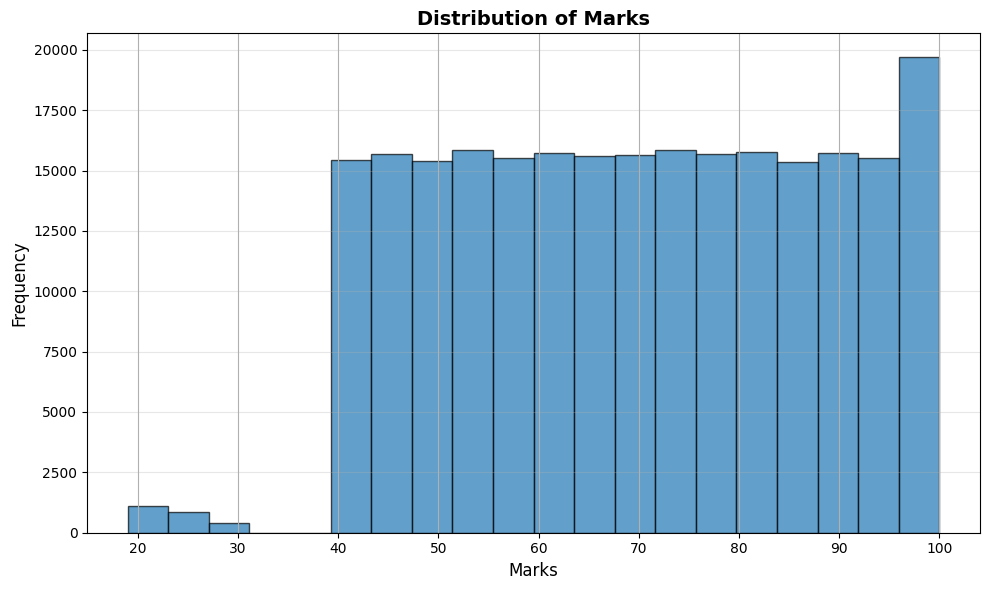

Marks Statistics:
  - Mean: 69.57
  - Median: 70.00
  - Std Dev: 18.10
  - Min: 19.00
  - Max: 100.00


In [ ]:
plt.figure(figsize=(10, 6))
clean_df["Marks"].hist(bins=20, edgecolor='black', alpha=0.7)
plt.title("Distribution of Marks", fontsize=14, fontweight='bold')
plt.xlabel("Marks", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Marks Statistics:")
print(f"  - Mean: {clean_df['Marks'].mean():.2f}")
print(f"  - Median: {clean_df['Marks'].median():.2f}")
print(f"  - Std Dev: {clean_df['Marks'].std():.2f}")
print(f"  - Min: {clean_df['Marks'].min():.2f}")
print(f"  - Max: {clean_df['Marks'].max():.2f}")

### Visualizations: marks distribution and effort vs marks
### Note: there is one extreme outlier at ~270 hours; it is left unchanged and outside this view.


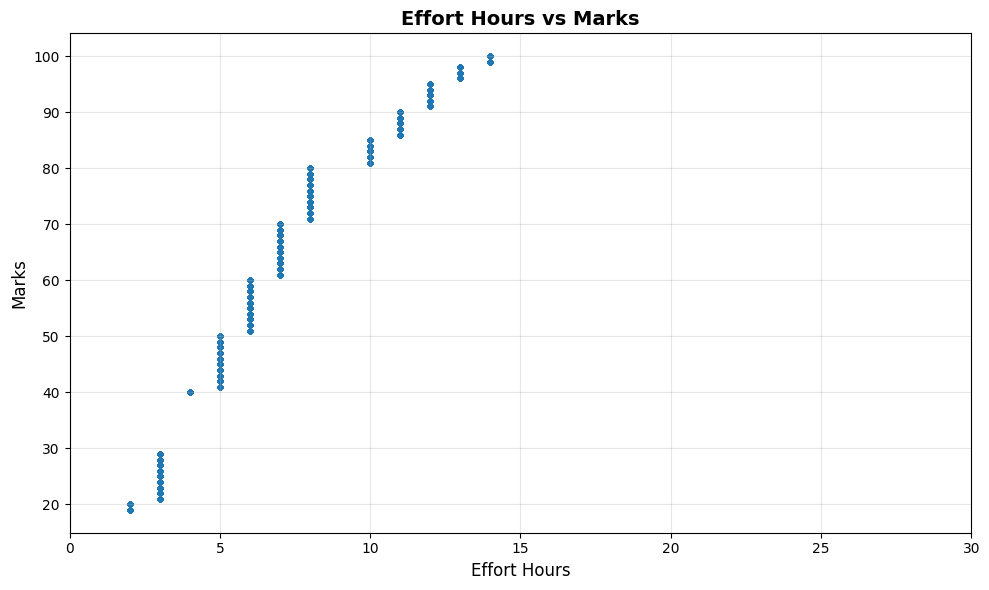

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(clean_df["Effort_Hours"], clean_df["Marks"], alpha=0.5, s=10)
# Focus x-axis on 0-30 to show the main distribution.
plt.xlim(0, 30)
plt.title("Effort Hours vs Marks", fontsize=14, fontweight='bold')
plt.xlabel("Effort Hours", fontsize=12)
plt.ylabel("Marks", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Analysis: average marks by department



Top 20 Departments by Average Marks:


,Count,Mean,Median,Std
Department_Name,,,,
Sophisticated Analytical Instrument Facility (SAIF),6313,70.08,70.0,17.93
Centre of Studies in Resources Engineering (CSRE),5051,69.95,70.0,18.06
Centre of Studies in Craft Engineering (CSCE),5051,69.95,70.0,18.06
Centre for Distance Engineering Education Programme (CDEEP),5321,69.91,70.0,18.22
National Centre for Aerospace Innovation and Research (NCAIR),4731,69.89,70.0,18.18
Center for Learning and Teaching (PPCCLT),9758,69.87,70.0,18.22
Centre for Technology Alternatives for Rural Areas (CTARA),5640,69.85,70.0,17.95
Civil Engineering,5100,69.82,70.0,18.04
Chemical Engineering,6819,69.78,70.0,18.02


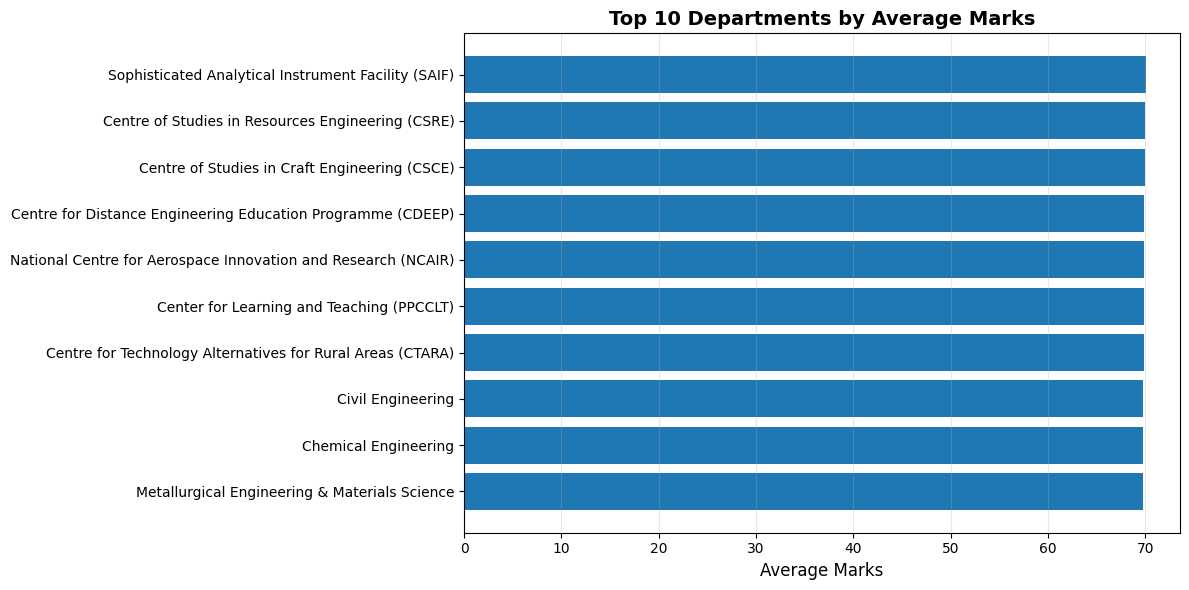

In [ ]:
# Calculate average marks per department
avg_dept = clean_df.groupby("Department_Name")["Marks"].agg([
    ('Count', 'count'),
    ('Mean', 'mean'),
    ('Median', 'median'),
    ('Std', 'std')
]).round(2).sort_values('Mean', ascending=False)

print("\nTop 20 Departments by Average Marks:")
display(avg_dept.head(20))

# Visualization
plt.figure(figsize=(12, 6))
top_10_dept = avg_dept.head(10)
plt.barh(range(len(top_10_dept)), top_10_dept['Mean'])
plt.yticks(range(len(top_10_dept)), top_10_dept.index)
plt.xlabel('Average Marks', fontsize=12)
plt.title('Top 10 Departments by Average Marks', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


### Predictive modeling: define helper function
### - A simple linear regression per student using Effort_Hours -> Marks.

In [ ]:
def predict_next_mark(df, student_id, effort_hours=10):
    """
    Predict the next mark for a student based on their historical performance.
    
    Parameters:
    - df: DataFrame with student performance data
    - student_id: Student ID to predict for
    - effort_hours: Effort hours for next paper (default=10)
    
    Returns:
    - Dictionary with prediction results
    """
    # Filter data for this student
    student_data = df[
        (df["Student_ID"] == student_id) & 
        (df["Effort_Hours"].notna()) & 
        (df["Marks"].notna())
    ]
    
    # Check if we have enough data points
    if len(student_data) < 2:
        return {
            "Student_ID": student_id,
            "Predicted_Mark": None,
            "Note": "Insufficient data (need at least 2 data points)"
        }
    
    # Prepare data for regression
    X = student_data[["Effort_Hours"]].values
    y = student_data["Marks"].values
    
    # Train linear regression model
    model = LinearRegression()
    model.fit(X, y)
    
    # Make prediction
    predicted_mark = model.predict([[effort_hours]])[0]
    
    # Calculate model metrics
    r_squared = model.score(X, y)
    
    return {
        "Student_ID": student_id,
        "Predicted_Mark": round(predicted_mark, 2),
        "Effort_Hours": effort_hours,
        "Data_Points": len(student_data),
        "R_Squared": round(r_squared, 4),
        "Coefficient": round(model.coef_[0], 4),
        "Intercept": round(model.intercept_, 4)
    }

print("Prediction function defined")

Prediction function defined


### Predictions for target students
### - Predict next paper mark for each target student using a fixed effort value.
### - Attach department info and clamp predicted marks to [0,100].

In [ ]:
# Target students as specified in assignment
TARGET_STUDENTS = ["SID20131151", "SID20149500", "SID20182516"]
EFFORT_HOURS = 10

# Make predictions
prediction_results = []
for student_id in TARGET_STUDENTS:
    result = predict_next_mark(clean_df, student_id, EFFORT_HOURS)
    prediction_results.append(result)
    
    print(f"\n{'='*50}")
    print(f"Student: {student_id}")
    print(f"{'='*50}")
    if result["Predicted_Mark"] is not None:
        print(f"  Predicted Mark: {result['Predicted_Mark']}/100")
        print(f"  Effort Hours: {result['Effort_Hours']}")
        print(f"  Historical Data Points: {result['Data_Points']}")
        print(f"  Model R²: {result['R_Squared']}")
        print(f"  Equation: Mark = {result['Coefficient']:.4f} × Effort + {result['Intercept']:.4f}")
    else:
        print(f" {result['Note']}")

# Create results DataFrame
predictions_df = pd.DataFrame(prediction_results)

# Add department information
student_dept = clean_df.groupby("Student_ID").agg({
    "Department_ID": lambda x: x.mode()[0] if len(x.mode()) > 0 else None,
    "Department_Name": lambda x: x.mode()[0] if len(x.mode()) > 0 else None
}).reset_index()

predictions_df = predictions_df.merge(
    student_dept,
    on="Student_ID",
    how="left"
)

print("\n" + "="*60)
print("FINAL PREDICTION RESULTS")
print("="*60)
display(predictions_df[["Student_ID", "Predicted_Mark", "Department_ID", "Department_Name"]])


Student: SID20131151
  Predicted Mark: 81.92/100
  Effort Hours: 10
  Historical Data Points: 55
  Model R²: 0.9449
  Equation: Mark = 6.3500 × Effort + 18.4154

Student: SID20149500
  Predicted Mark: 82.25/100
  Effort Hours: 10
  Historical Data Points: 112
  Model R²: 0.9309
  Equation: Mark = 6.5647 × Effort + 16.6069

Student: SID20182516
  Predicted Mark: 82.17/100
  Effort Hours: 10
  Historical Data Points: 55
  Model R²: 0.9323
  Equation: Mark = 6.1540 × Effort + 20.6298

FINAL PREDICTION RESULTS


,Student_ID,Predicted_Mark,Department_ID,Department_Name
0,SID20131151,81.92,IDEPT6347,Sophisticated Analytical Instrument Facility (...
1,SID20149500,82.25,IDEPT4308,Climate Studies
2,SID20182516,82.17,IDEPT3062,Centre for Environmental Science and Engineeri...


### Visualize individual student fits (if data available)


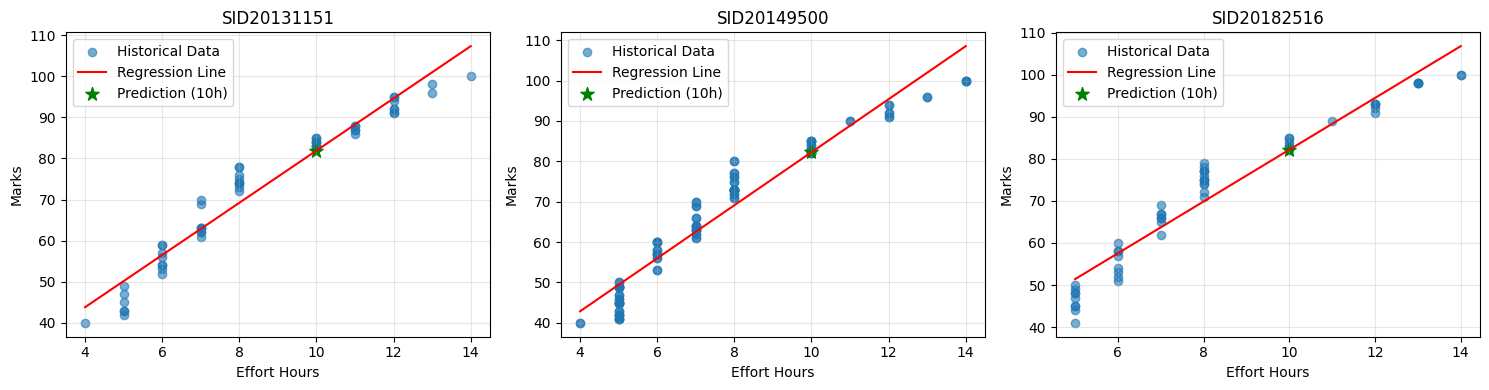

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, student_id in enumerate(TARGET_STUDENTS):
    student_data = clean_df[
        (clean_df["Student_ID"] == student_id) & 
        (clean_df["Effort_Hours"].notna()) & 
        (clean_df["Marks"].notna())
    ]
    
    if len(student_data) >= 2:
        # Fit model
        X = student_data[["Effort_Hours"]].values
        y = student_data["Marks"].values
        model = LinearRegression()
        model.fit(X, y)
        
        # Create regression line
        X_line = np.linspace(X.min(), max(X.max(), 10), 100)
        y_line = model.predict(X_line.reshape(-1, 1))
        
        # Plot
        axes[idx].scatter(X, y, alpha=0.6, label='Historical Data')
        axes[idx].plot(X_line, y_line, 'r-', label='Regression Line')
        axes[idx].scatter([10], [model.predict([[10]])[0]], 
                         color='green', s=100, marker='*', 
                         label='Prediction (10h)')
        axes[idx].set_xlabel('Effort Hours')
        axes[idx].set_ylabel('Marks')
        axes[idx].set_title(f'{student_id}')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Export exception reports
### - Writes each DataFrame in `reports` to reports/<name>.csv and a summary CSV.

In [ ]:
REPORT_DIR = "reports"
os.makedirs(REPORT_DIR, exist_ok=True)

summary_rows = []
for report_name, report_df in reports.items():
    out_path = os.path.join(REPORT_DIR, f"{report_name}.csv")
    report_df.to_csv(out_path, index=False)
    summary_rows.append({
        "Report_Name": report_name,
        "Exception_Count": len(report_df),
        "File_Path": out_path
    })
    print(f"Exported: {out_path} ({len(report_df)} rows)")

# Create summary report
report_summary = pd.DataFrame(summary_rows)
summary_path = os.path.join(REPORT_DIR, "00_SUMMARY.csv")
report_summary.to_csv(summary_path, index=False)
print(f"\nSummary saved to: {summary_path}")

display(report_summary)

Exported: reports\dept_missing.csv (2 rows)
Exported: reports\dept_duplicate_id.csv (10 rows)
Exported: reports\dept_duplicate_name.csv (2 rows)
Exported: reports\dept_invalid_doe.csv (3 rows)
Exported: reports\coun_missing.csv (1 rows)
Exported: reports\coun_bad_admission.csv (1 rows)
Exported: reports\perf_missing.csv (3 rows)
Exported: reports\perf_bad_marks.csv (5 rows)
Exported: reports\perf_bad_effort.csv (1 rows)
Exported: reports\perf_dup_pair.csv (0 rows)

Summary saved to: reports\00_SUMMARY.csv


,Report_Name,Exception_Count,File_Path
0,dept_missing,2,reports\dept_missing.csv
1,dept_duplicate_id,10,reports\dept_duplicate_id.csv
2,dept_duplicate_name,2,reports\dept_duplicate_name.csv
3,dept_invalid_doe,3,reports\dept_invalid_doe.csv
4,coun_missing,1,reports\coun_missing.csv
5,coun_bad_admission,1,reports\coun_bad_admission.csv
6,perf_missing,3,reports\perf_missing.csv
7,perf_bad_marks,5,reports\perf_bad_marks.csv
8,perf_bad_effort,1,reports\perf_bad_effort.csv
9,perf_dup_pair,0,reports\perf_dup_pair.csv


### Export predictions
### - Saves final predictions CSV for submission.

In [ ]:

OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Create final output with required columns
final_output = predictions_df[[
    "Student_ID", 
    "Predicted_Mark", 
    "Department_ID", 
    "Department_Name"
]].copy()

# Rename for clarity
final_output.columns = [
    "Student_ID",
    "Predicted Score in next paper",
    "Department_ID",
    "Department"
]

output_path = os.path.join(OUTPUT_DIR, "predicted_marks.csv")
final_output.to_csv(output_path, index=False)

print(f"Predictions saved to: {output_path}")
print("\nFinal Output:")
display(final_output)

Predictions saved to: outputs\predicted_marks.csv

Final Output:


,Student_ID,Predicted Score in next paper,Department_ID,Department
0,SID20131151,81.92,IDEPT6347,Sophisticated Analytical Instrument Facility (...
1,SID20149500,82.25,IDEPT4308,Climate Studies
2,SID20182516,82.17,IDEPT3062,Centre for Environmental Science and Engineeri...


In [ ]:
conn.close()
print("\nDatabase connection closed")


Database connection closed
